<a href="https://colab.research.google.com/github/IverMartinsen/uncertainty/blob/main/cifar10_psgld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! git clone https://github.com/IverMartinsen/uncertainty.git

fatal: destination path 'uncertainty' already exists and is not an empty directory.


In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from uncertainty.pSGLD import pSGLangevinDynamics

### Hyperparameters

In [14]:
n = 50000 # sample size, needed for scaling the optimizer
batch_size = 512
epochs = 100
prior_precision = 0.01

# optimizer
base_learning_rate = 0.001
lr_decay_rate = 0.9
diagonal_bias = 1e-8 # lambda parameter in the paper
preconditioner_decay_rate = 0.95 # alpha parameter in the paper
burnin = 1 * n // batch_size # number of training steps before starting to add gradient noise

### Load data and define model

In [22]:
ds_train, ds_test = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, batch_size=batch_size)

# adding a prior to the weights
regularizer = tf.keras.regularizers.l2(prior_precision)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=regularizer, bias_regularizer=regularizer)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 64)         

### Visualize learning rate schedule

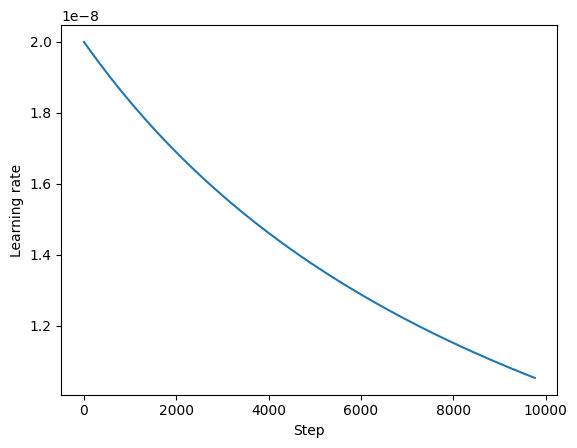

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=base_learning_rate / n,
    decay_steps=epochs*n//(batch_size),
    decay_rate=lr_decay_rate,
    staircase=False
)

plt.plot(lr_schedule(tf.range(epochs*n//batch_size)))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.show()


### Train the model

In [18]:
optimizer = pSGLangevinDynamics(
    learning_rate=lr_schedule,
    rho=preconditioner_decay_rate,
    epsilon=diagonal_bias,
    burnin=burnin,
    data_size=n,
    )

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


class RecordParametersCallback(tf.keras.callbacks.Callback):
    """
    To record parameters during training.
    """
    def __init__(self):
        super().__init__()
        self.parameters = []
    def on_epoch_end(self, epoch, logs=None):
        self.parameters.append(model.get_weights())


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

callback = RecordParametersCallback()

model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[callback], shuffle=True)

Epoch 1/100
98/98 [==============================] - 19s 76ms/step - loss: 6.6327 - accuracy: 0.2373 - val_loss: 3.1648 - val_accuracy: 0.3228
Epoch 2/100
98/98 [==============================] - 2s 16ms/step - loss: 2.9389 - accuracy: 0.3697 - val_loss: 2.7308 - val_accuracy: 0.4343
Epoch 3/100
98/98 [==============================] - 2s 17ms/step - loss: 2.6449 - accuracy: 0.4492 - val_loss: 2.5599 - val_accuracy: 0.4780
Epoch 4/100
98/98 [==============================] - 2s 18ms/step - loss: 2.4567 - accuracy: 0.4954 - val_loss: 2.5784 - val_accuracy: 0.4407
Epoch 5/100
98/98 [==============================] - 2s 15ms/step - loss: 2.3248 - accuracy: 0.5342 - val_loss: 2.3748 - val_accuracy: 0.5142
Epoch 6/100
98/98 [==============================] - 1s 15ms/step - loss: 2.2307 - accuracy: 0.5597 - val_loss: 2.2418 - val_accuracy: 0.5480
Epoch 7/100
98/98 [==============================] - 1s 15ms/step - loss: 2.1557 - accuracy: 0.5789 - val_loss: 2.1662 - val_accuracy: 0.5759
Epoch

In [19]:
parameters = callback.parameters